In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import logging
import random
from sklearn.manifold import TSNE

tf.get_logger().setLevel(logging.ERROR)

DR_RATE = .2



In [2]:
# TO AVOID USING GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

# Descarga de datos 

In [3]:
# Load traditional MNIST dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (_, _) = mnist.load_data()

# Scale the data.
train_images = train_images / 255.0



# VAE

In [4]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    Uses the Reparametrization Trick."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [5]:
latent_dim = 50

encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

2022-08-10 22:17:17.986339: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-10 22:17:17.986405: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-F6C1SAK): /proc/driver/nvidia/version does not exist
2022-08-10 22:17:17.987173: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Decoder

In [6]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              159936    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

# Variational autoencoder

In [7]:
from tensorflow.keras import backend as K
class VAE(keras.Model):
    def __init__(self, encoder, decoder, recons_loss_factor=1_000, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.recons_loss_factor = recons_loss_factor
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

    def compute_losses(self, data):
        reconstruction, z_mean, z_log_var = self.call(data)

        # Reconstruction loss thorugh mse
        reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction), axis = [1,2,3])
        
        # Reconstruction loss through binary crossentropy
        # reconstruction_loss = keras.losses.binary_crossentropy(K.batch_flatten(data) , K.batch_flatten(reconstruction), axis=-1)

        # KL Divergence loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - K.exp(z_log_var), axis = -1)


        # Total loss is sum of both losses
        total_loss = self.recons_loss_factor * reconstruction_loss + kl_loss
        return reconstruction_loss, kl_loss, total_loss
    
    def train_step(self, data):
        """Defines how the model must be trained"""

        with tf.GradientTape() as tape:
            # For all operationes here, the graphs of the gradients will be recorded and stored in tape
            reconstruction_loss, kl_loss, total_loss = self.compute_losses(data)

            total_loss = K.mean(total_loss, axis=0)
            kl_loss = K.mean(kl_loss, axis=0)
            reconstruction_loss = K.mean(reconstruction_loss, axis=0)


        # Computes the gradient
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # Changes the weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Updates the metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):

        reconstruction_loss, kl_loss, total_loss = self.compute_losses(data)


        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [8]:
vae_model = VAE(encoder, decoder, recons_loss_factor=10_000, name="vae")
vae_model.compile("adam")

In [9]:

history = vae_model.fit(np.expand_dims(train_images, -1), epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 25s 16ms/step - loss: 685.9995 - reconstruction_loss: 0.0535 - kl_loss: 21.6879 - val_loss: 469.0739 - val_reconstruction_loss: 0.0442 - val_kl_loss: 27.3551
Epoch 2/10
1500/1500 [==============================] - 25s 17ms/step - loss: 459.0819 - reconstruction_loss: 0.0423 - kl_loss: 26.0417 - val_loss: 430.4097 - val_reconstruction_loss: 0.0404 - val_kl_loss: 26.5769
Epoch 3/10
1500/1500 [==============================] - 25s 17ms/step - loss: 426.7684 - reconstruction_loss: 0.0398 - kl_loss: 24.4428 - val_loss: 407.1858 - val_reconstruction_loss: 0.0383 - val_kl_loss: 23.9951
Epoch 4/10
1500/1500 [==============================] - 25s 17ms/step - loss: 408.4417 - reconstruction_loss: 0.0383 - kl_loss: 23.0738 - val_loss: 396.7452 - val_reconstruction_loss: 0.0374 - val_kl_loss: 23.2076
Epoch 5/10
1500/1500 [==============================] - 27s 18ms/step - loss: 398.2896 - reconstruction_loss: 0.0374 - kl_loss: 22.2829 - val_lo

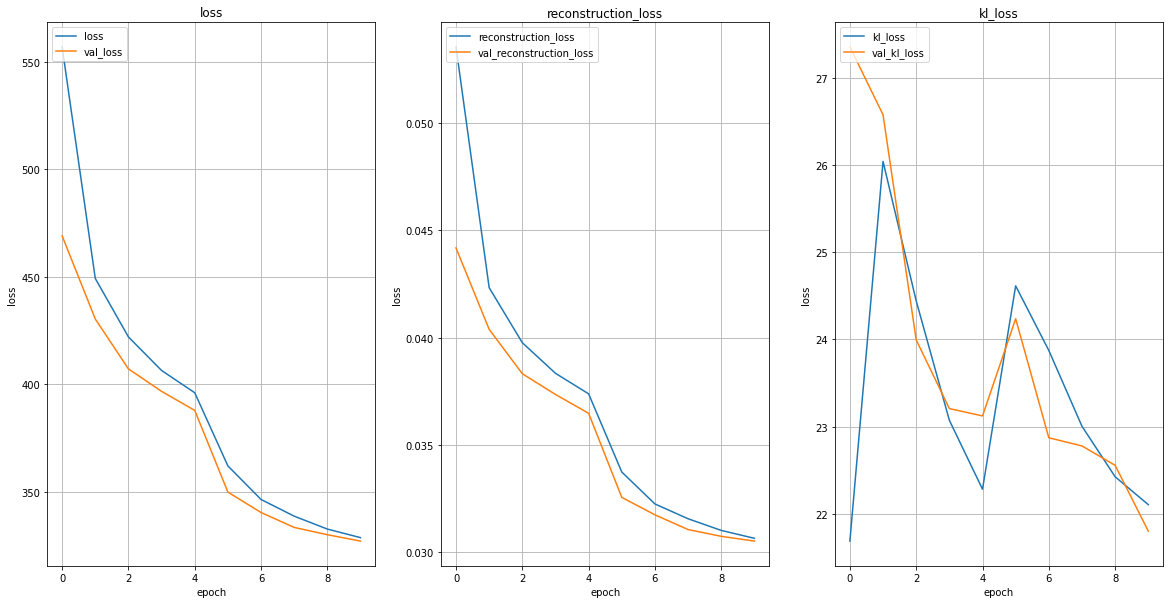

In [10]:
metrics_to_plot = [m for m in history.history.keys() if "val_" not in m]

fig, axs = plt.subplots(1, len(metrics_to_plot), figsize=(20, 10))
for m, ax in zip(metrics_to_plot, axs.flatten()):
    ax.plot(history.history[m], label=m)
    ax.plot(history.history["val_" + m], label="val_" + m)
    
    ax.set_title(m)
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(loc='upper left')
    ax.grid()

# Reconstrucción

In [11]:
train_predictions = vae_model.predict(np.expand_dims(train_images, -1))[0].squeeze()
errors = np.mean(np.abs(train_images - train_predictions), (1, 2))
indices_ordered_by_error = sorted(enumerate(errors), key=lambda x: x[1], reverse=True)

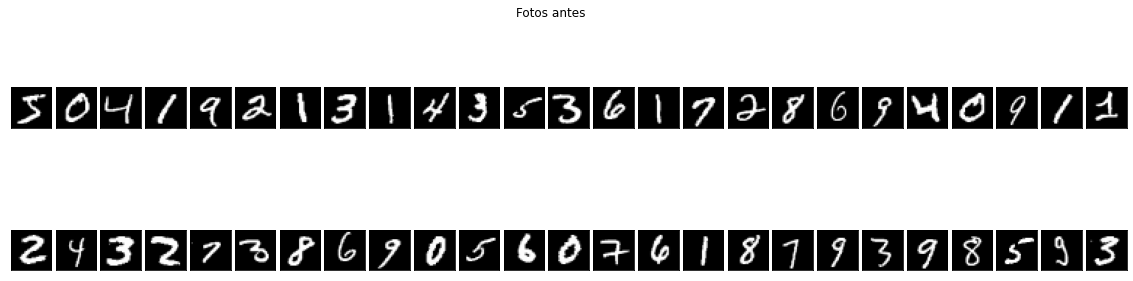

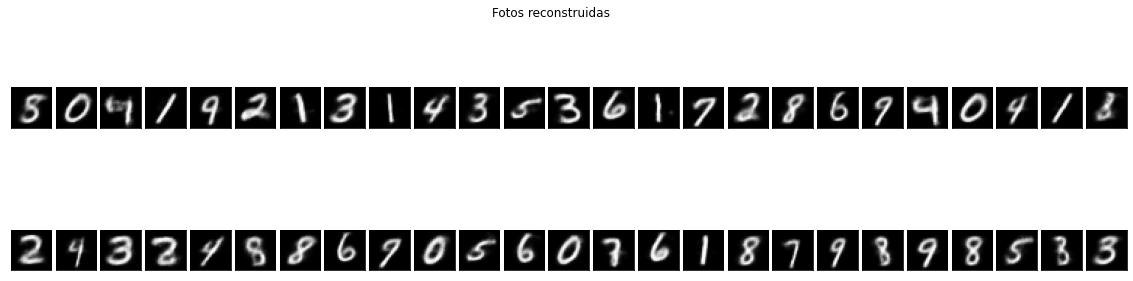

In [12]:
N = 50
fig, axs = plt.subplots(2, N // 2, figsize=(20, 5), 
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for sample, ax in zip(train_images, axs.flatten()):
    ax.imshow(sample, cmap=plt.get_cmap('gray'))
plt.suptitle("Fotos antes")

fig, axs = plt.subplots(2, N // 2, figsize=(20, 5), 
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for sample, ax in zip(train_predictions, axs.flatten()):
    ax.imshow(sample, cmap=plt.get_cmap('gray'))
plt.suptitle("Fotos reconstruidas");

# Caso de uso: Modelo generativo

In [13]:
number_a = 10
number_b = 40

In [14]:
embeddings = encoder.predict(train_images)[2].squeeze()

In [15]:
embeddings_a = embeddings[number_a, :]
embeddings_b = embeddings[number_b, :]


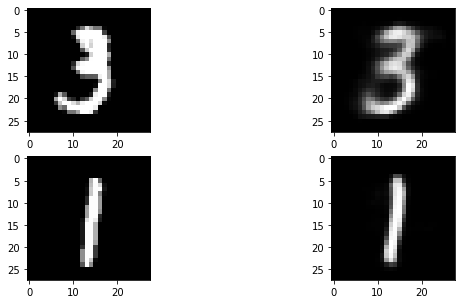

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0][0].imshow(train_images[number_a].squeeze(), cmap='gray')
axs[0][1].imshow(decoder.predict(np.expand_dims(embeddings_a, 0)).squeeze(), cmap='gray')

axs[1][0].imshow(train_images[number_b].squeeze(), cmap='gray')
axs[1][1].imshow(decoder.predict(np.expand_dims(embeddings_b, 0)).squeeze(), cmap='gray')


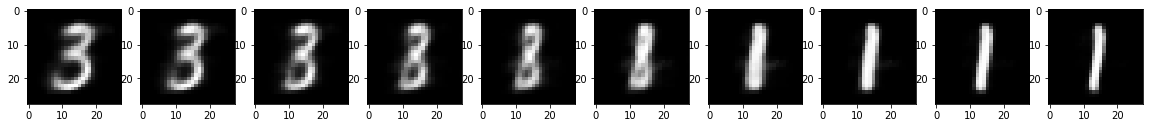

In [17]:
number_samples = 10

fig, axs = plt.subplots(1, number_samples, figsize=(20, 10))

v = embeddings_b - embeddings_a

for alpha, ax in zip(np.linspace(0, 1, number_samples), axs.flatten()):
    x = embeddings_a + alpha * v
    ax.imshow(decoder.predict(np.expand_dims(x, 0)).squeeze(), cmap='gray')